In [1]:
import tsplib95
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import csv
import time
import pandas as pd

In [2]:
def load_tsp_file_with_txt(file_path):
    problem = tsplib95.load(file_path)
    
    # get node coordinates
    coordinates = []
    for node in problem.get_nodes():
        coord = problem.node_coords[node]
        coordinates.append((coord[0], coord[1]))
    
    return np.array(coordinates)

# Load the data
cities = load_tsp_file_with_txt('eil51.txt')
print(np.shape(cities))
print("Loaded Cities' Coordinates:")
print(cities)


(51, 2)
Loaded Cities' Coordinates:
[[37 52]
 [49 49]
 [52 64]
 [20 26]
 [40 30]
 [21 47]
 [17 63]
 [31 62]
 [52 33]
 [51 21]
 [42 41]
 [31 32]
 [ 5 25]
 [12 42]
 [36 16]
 [52 41]
 [27 23]
 [17 33]
 [13 13]
 [57 58]
 [62 42]
 [42 57]
 [16 57]
 [ 8 52]
 [ 7 38]
 [27 68]
 [30 48]
 [43 67]
 [58 48]
 [58 27]
 [37 69]
 [38 46]
 [46 10]
 [61 33]
 [62 63]
 [63 69]
 [32 22]
 [45 35]
 [59 15]
 [ 5  6]
 [10 17]
 [21 10]
 [ 5 64]
 [30 15]
 [39 10]
 [32 39]
 [25 32]
 [25 55]
 [48 28]
 [56 37]
 [30 40]]


In [3]:
def euclidean_distance(city1, city2):
    return np.linalg.norm(city1 - city2)

def compute_distance_matrix(cities):
    """Computes distance between two cities 
    Returns: Distance matrix 
    """
    num_cities = len(cities)
    dist_matrix = np.zeros((num_cities, num_cities))
    for i in range(num_cities):
        for j in range(num_cities):
            if i != j:
                dist_matrix[i][j] = euclidean_distance(cities[i], cities[j])
    return dist_matrix

distance_matrix = compute_distance_matrix(cities)

def calculate_total_distance(tour, dist_matrix):
    """Calculate total distance of one tour (defined as array of cities)"""
    total_distance = 0
    num_cities = len(tour)
    for i in range(num_cities):
        total_distance += dist_matrix[tour[i]][tour[(i + 1) % num_cities]]
    return total_distance

def generate_initial_solution(num_cities):
    """Initialize a random tour"""
    tour = list(range(num_cities))
    random.shuffle(tour)
    return tour


initial_tour = generate_initial_solution(len(cities))
print("Initial Tour:", initial_tour)
print("Initial Distance:", calculate_total_distance(initial_tour, distance_matrix))



Initial Tour: [23, 47, 26, 34, 7, 50, 45, 46, 44, 17, 2, 9, 10, 28, 20, 30, 27, 29, 13, 5, 0, 16, 38, 18, 8, 32, 31, 35, 12, 21, 48, 24, 4, 25, 19, 6, 22, 40, 49, 41, 33, 3, 14, 1, 43, 37, 11, 42, 15, 39, 36]
Initial Distance: 1652.8735609334055


In [4]:
def cooling_schedule(cooling_type, k, cooling_rate, initial_temperature, current_temperature):
    # linear cooling: new temp = current_temperature - cooling_rate
    if cooling_type == "linear":
        return current_temperature - cooling_rate
    # geometric cooling: new temp = current_temperature * cooling_rate
    elif cooling_type == "geometric":
        return current_temperature * cooling_rate
    # exponential cooling: new temp = initial_temperature * cooling_rate^k
    elif cooling_type == "exponential":
        return initial_temperature * (cooling_rate ** k)
    # logarithmic cooling: new temp = initial_temperature / log(k + 1)
    elif cooling_type == "logarithmic":
        # prevent division by zero
        if k == 0:
            return initial_temperature
        return initial_temperature / math.log(k + 1)
    else:
        raise ValueError("Invalid cooling type")

In [5]:
def two_opt_swap(tour, i, k):
    """Perform a 2-opt swap by reversing the segment between i and k"""
    new_tour = tour[:i] + tour[i:k + 1][::-1] + tour[k + 1:]
    return new_tour

def simulated_annealing(cities, initial_temperature, cooling_rate, markov_length, cooling_type="geometric"):
    """Simulated annealing of travlling salesman
    
    Input: 
    cities (shape=(n,2) np.array) : coordinates of cities
    initial_temperature (float)
    cooling_rate: rate [0,1] of cooling per simulation step (slow cooling > 1, better result but slower)
    markov_length: number of candidate solutions generated and evaluated at each temperature step
    cooling_type: type of cooling function: linear, geometric, exponential, logarithmic
    
    Return:
    best_solution: best tour found
    best_distance: distance of best tour
    iteration: number of iterations
    """
    num_cities = len(cities)
    dist_matrix = compute_distance_matrix(cities)
    # Generate random tour
    current_solution = generate_initial_solution(num_cities)
    current_distance = calculate_total_distance(current_solution, dist_matrix)
    best_solution = current_solution
    best_distance = current_distance
    
    temperature = initial_temperature

    results_each_iteration = []
    iteration = 0
    distances = []
    temperatures = []

    #for iteration in range(max_iterations):
    while temperature > 0.01:
        iteration += 1
        for _ in range(markov_length):
            # Generate a new solution with a 2-opt move
            i, k = sorted(random.sample(range(num_cities), 2))
            new_solution = two_opt_swap(current_solution, i, k)
            new_distance = calculate_total_distance(new_solution, dist_matrix)
            
            # Calculate the change in distance
            delta = new_distance - current_distance

            # Accept the new solution based on the acceptance probability
            if delta < 0 or random.random() < math.exp(-delta / temperature):
                current_solution = new_solution
                current_distance = new_distance

                # Update the best solution if needed
                if current_distance < best_distance:
                    best_solution = current_solution
                    best_distance = current_distance
        temperatures.append(temperature)
        distances.append(current_distance)
        
        # Cool down the temperature
        temperature = cooling_schedule(cooling_type, iteration, cooling_rate, initial_temperature, temperature)

        # Optional: Print progress
        results_each_iteration.append([iteration, temperature, best_distance])
        print(f"Iteration {iteration}, Temperature: {temperature:.2f}, Best Distance: {best_distance:.2f}")

    return best_solution, distances, temperatures, iteration, results_each_iteration


In [ ]:
# # test simulated annealing with a standard cooling type to figure out the minimum
# best_tour,distances,temperatures,max_iter, _ = simulated_annealing(
#     cities=cities,
#     initial_temperature=8000,
#     cooling_rate=0.995,
#     markov_length=400,
#     cooling_type="geometric"
# )

# print("Best Tour:", best_tour)
# print("Best Distance:", distances[-1])

In [6]:
def plot_tour(cities, tour):
    tour_cities = cities[tour + [tour[0]]]  # Complete the loop
    plt.figure(figsize=(10, 6))
    plt.plot(tour_cities[:, 0], tour_cities[:, 1], 'o-', markerfacecolor='red')
    plt.title("Best Tour Found")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.grid(True)
    plt.show()

# plot_tour(cities, best_tour)

In [7]:
def run_simulated_annealing_statistics(cities, initial_temperature, cooling_rate, markov_length, cooling_type, N):
    min_distances = []

    for i in range(N):
        _, best_distance, _,_ = simulated_annealing(cities, initial_temperature, cooling_rate, markov_length, cooling_type)
        min_distances.append(best_distance)
        print(f"Run {i + 1}/{N}: Best Distance = {best_distance:.2f}")

    return min_distances

def plot_histogram(min_distances,N):
    plt.figure(figsize=(10, 6))
    plt.hist(min_distances, bins=15, color='skyblue', edgecolor='black')
    plt.title(f"Histogram of Minimum Distances Found Over {N} Runs")
    plt.xlabel("Distance")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

# initial_temperature = 10000
# cooling_rate = 0.9999
# markov_length = 1000
# cooling_type = "geometric"
# N = 20 # Number of runs

#min_distances = run_simulated_annealing_statistics(cities, initial_temperature, cooling_rate, markov_length, cooling_type, N)

#plot_histogram(min_distances,N)

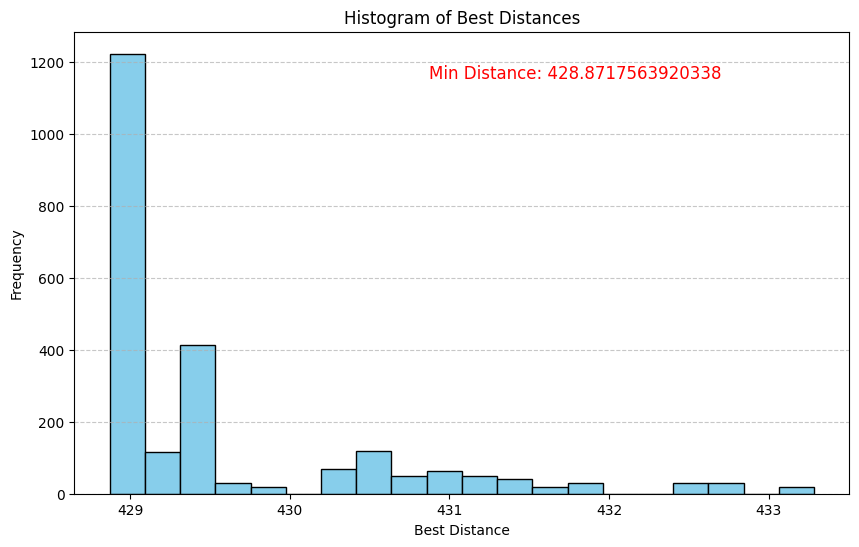

In [8]:
# Load the CSV file
filename = "simulation_results_eil51_8000_0.999_1000.csv"
df = pd.read_csv(filename)

# Plot the histogram of the "Best Distance" column
plt.figure(figsize=(10, 6))
plt.hist(df['Best Distance'], bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of Best Distances')
plt.xlabel('Best Distance')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the minimum distance on the plot
min_distance = df['Best Distance'].min()
plt.text(min_distance + 2, plt.ylim()[1] * 0.9, f'Min Distance: {min_distance}', color='red', fontsize=12)
plt.savefig("hist.png")
plt.show()


In [12]:
def compute_equivalent_cooling_rate(T_0, cr_geo=None, k=None, c=None, method=None):
    """
    calculate the cooling rate dynamically to have equivalent results across schedules
    """
    if method == "linear":
        if cr_geo is None:
            raise ValueError("cr geo must be provided for linear cooling")
        return T_0 * (1 - cr_geo) 

    elif method == "exponential":
        if k is None or c is None:
            raise ValueError("k and c must be provided for exponential cooling")
        return math.exp(-k / c)

    else:
        raise ValueError("choose cooling method")


In [9]:
def cooling_schedule(cooling_type, k, cooling_rate, initial_temperature, current_temperature):
    # linear cooling: new temp = current_temperature - cooling_rate
    if cooling_type == "linear":
        return current_temperature - compute_equivalent_cooling_rate(initial_temperature, cooling_rate, method="linear")
    # geometric cooling: new temp = current_temperature * cooling_rate
    elif cooling_type == "geometric":
        return current_temperature * cooling_rate
    # exponential cooling: new temp = initial_temperature * cooling_rate^k
    elif cooling_type == "exponential":
        return initial_temperature * (compute_equivalent_cooling_rate(initial_temperature, cooling_rate, k, 1, "exponential") ** k)
    # logarithmic cooling: new temp = initial_temperature / log(k + 1)
    elif cooling_type == "logarithmic":
        # prevent division by zero
        if k == 0:
            return initial_temperature
        return initial_temperature / math.log(k + 1)
    else:
        raise ValueError("Invalid cooling type")

In [13]:
# test the function for all cooling types
initial_temperature = 50
cooling_rate = 0.995
k = 10

print("Linear Cooling Rate:", compute_equivalent_cooling_rate(initial_temperature, cr_geo=cooling_rate, method="linear"))
print("Exponential Cooling Rate:", compute_equivalent_cooling_rate(initial_temperature, k=k, c=cooling_rate, method="exponential"))

Linear Cooling Rate: 0.2500000000000002
Exponential Cooling Rate: 4.3174899732660524e-05


In [ ]:

simulation_results = []

num_runs = 100
initial_temperature = 8000
cooling_rate = 0.995
markov_length = 1000

cooling_types = ["geometric", "linear", "exponential", "logarithmic"]

def run_to_csv(cities, initial_temperature, cooling_rate, markov_length, cooling_type, num_runs):
    simulation_results = []
csv_filename = f'simulation_results_eil51_{initial_temperature}_{cooling_rate}_{markov_length}_cooling_types.csv'
with open(csv_filename, mode='w', newline='') as file:
    writer = csv.writer(file)

    # Write header
    writer.writerow(['Initial Temperature', 'Cooling Rate', 'Markov Length', 'Cooling Type', 'Max Iterations', 'Distances', 'Temperatures'])

    # Run simulations and write to CSV file
    for cooling_type in cooling_types:
        for run in range(1, num_runs + 1):
            best_solution, distances, temperatures, max_iter = simulated_annealing(
                cities=cities,
                initial_temperature=initial_temperature,
                cooling_rate=cooling_rate,
                markov_length=markov_length,
                cooling_type=cooling_type,
            )

            # Append the result and write a single row immediately
            row_data = [initial_temperature, cooling_rate, markov_length, cooling_type, max_iter, distances, temperatures]
            #simulation_results.append(row_data)
            writer.writerow(row_data)

        # Header
        writer.writerow(['Initial Temperature', 'Cooling Rate', 'Markov Length', 'Cooling Type', 'Max Iterations', 'Best Distance'])
        
        # Running simulations
        for run in range(1, num_runs + 1):
            best_solution, best_distance, max_iter = simulated_annealing(
                cities=cities,
                initial_temperature=initial_temperature,
                cooling_rate=cooling_rate,
                markov_length=markov_length,
                cooling_type=cooling_type
            )

            simulation_results.append([initial_temperature, cooling_rate, markov_length, cooling_type, max_iter, best_distance])

            # # Every run, save the results to CSV
            # if run % 1 == 0:
            #     writer.writerows(simulation_results[-10:])
            #     print(f"Results saved after {run} runs.")
            
            time.sleep(1)

print(f"Simulation completed. Results saved to {csv_filename}.")

